# Churn prediction for an energy company 🔌💡
## Part 3 - Model Building
### Importing packages and models

First, we import the necessary libraries and define key variables used throughout this notebook.

In [7]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# SAS models
from sasviya.ml.linear_model import LogisticRegression as SASLogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier as SASDecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as SASForestClassifier
from sasviya.ml.tree import GradientBoostingClassifier as SASGradientBoostingClassifier

# scikit-learn classes and models
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SKGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

from model_building_utils import *

target = 'churn'
repo_path = '/workspaces/myfolder/energy-churn-prediction'

### Model Building for non-transformed dataset

In this section, we train and evaluate models using both the `scikit-learn` and `sasviya` libraries. The `sasviya` library is the new **SAS Python API** available in **SAS Viya Workbench**, allowing seamless integration of SAS analytics into Python workflows.

We start by comparing the performance of equivalent models from both libraries using 3-fold cross-validation. Then, we conduct a more thorough evaluation and model selection process using `Optuna` for hyperparameter tuning.

This analysis is performed on both the non-transformed and transformed datasets, which were prepared in the `Churn Prediction - Part 2` notebook. Here, we begin with the non-transformed dataset.

In [8]:
merged_df_no_tfm = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")
merged_df_no_tfm.head(5)

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,has_gas,imp_cons,margin_net_pow_ele,...,price_off_peak_var_std,price_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_peak_fix_max_diff,product_modified,contract_age_at_last_modif,days_to_end
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,54946,0,0.00,0.0,1.78,Yes,0.00,25.44,...,0.007829,0.005126,1.050136,7.039226,0.028554,0.000568,0.097752,Yes,869,167
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,0,0,189.95,0.0,16.27,No,0.00,16.38,...,0.002212,0.024677,0.080404,0.000000,0.001567,0.085483,0.000000,No,0,243
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,0,0,47.96,0.0,38.72,No,0.00,28.60,...,0.002396,0.000506,0.087532,0.000000,0.000000,0.001281,0.000000,No,0,107
3,bba03439a292a1e166f80264c16191cb,Channel 2,0,0,240.04,0.0,19.83,No,0.00,30.22,...,0.002317,0.000000,0.080403,0.000000,0.000000,0.000000,0.000000,No,0,90
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,0,526,445.75,0.0,131.73,No,52.32,44.91,...,0.003847,0.001885,0.073681,0.044209,0.001969,0.001867,0.097749,No,0,67


Before training models, we split the dataset into training and test sets and generate lists of categorical and numerical columns.

In [9]:
X_train_no_tfm, X_test_no_tfm, y_train_no_tfm, y_test_no_tfm, cat_cols_no_tfm, cat_cols_with_two_values_no_tfm, cat_cols_with_more_values_no_tfm, numeric_cols_no_tfm = split_data_and_generate_column_lists(merged_df_no_tfm, target)

- Number of rows with churn='No': 13148 (90.35 %)
- Number of rows with churn='Yes': 1405 (9.65 %)


One way to evaluate the quality of a probability estimate is by examining the ranking it produces. A good probability estimate should rank all the minority class observations (e.g., churners) and then those from the majority class (e.g., non-churners). In other words, it should assign high probabilities to positive examples and low probabilities to negative ones. A widely used ranking measure for imbalanced datasets is **AUC (Area Under the ROC Curve)**. If a threshold exists that perfectly separates churners from non-churners, the AUC will be 1.
Since our goal is to create a reliable **scoring list** for a retention campaign targeting potential churners, we prioritize ranking quality over overall predictive accuracy. Therefore, we will use AUC as the evaluation metric to select the best-performing model.
Finally, since our main objective is to assess how well the model ranks customers, we can compare models with different prior distributions without adjusting the posterior probabilities, as the bias due to undersampling does not affect the ranking order returned by the posterior probability.

For more information, check out [this article](https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf).

To get a quick comparison of the `scikit-learn` and `sasviya` models, we will evaluate their performance using **3-fold cross-validation** and without applying undersampling.

For this purpose, we will use the custom `train_and_evaluate_model` function, which constructs a pipeline for each model. This pipeline consists of three preprocessing steps before training the model:

- `MissingValueImputer`: Handles missing values in numeric columns by using a `sasviya` `DecisionTreeRegressor` to impute them.
- `DataScaler`: Standardizes numeric features to ensure consistent scaling. This step is included in the pipeline only if the `numeric_cols` parameter is provided with a list of numeric columns.
- `CategoricalLevelFilter`: Filters out rows with categorical values that were not observed in the training set, ensuring consistency in evaluation.

In addition, the `scikit-learn` models require a pre-processing step to properly encode categorical variables. This is not needed for `sasviya` models, as they automatically handle nominal columns by simply passing their names to the `nominals` parameter during training. For more details on how a nominal variable is evaluated by a SAS model, see [here](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbcasml/vwbcasml_forest_details04.htm), for example.

Then, the function computes the AUC scores for both the training and validation sets. Before calculating AUC, the validation set is filtered to remove rows with categorical values not present in the training set. This is managed through the `levels` attribute of the `CategoricalLevelFilter` transformer, which stores the distinct values of each categorical feature seen during training.

Since we are not applying undersampling for this comparison, the models will be trained on the full dataset without adjusting class distributions. This will serve as an initial performance benchmark before introducing random undersampling in the next section to assess their impact on model performance.

In [10]:
k = 3
metrics_list = []

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values_no_tfm)), cat_cols_with_two_values_no_tfm),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values_no_tfm)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)
models = [
    (SASLogisticRegression(), "Logistic Regression", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor),('classifier', SKLogisticRegression(solver='liblinear'))]), "Logistic Regression", "scikit-learn"),
    (SASDecisionTreeClassifier(), "Decision Tree", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKDecisionTreeClassifier())]), "Decision Tree", "scikit-learn"),
    (SASForestClassifier(), "Random Forest", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKRandomForestClassifier())]), "Random Forest", "scikit-learn"),
    (SASGradientBoostingClassifier(), "Gradient Boosting", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKGradientBoostingClassifier())]), "Gradient Boosting", "scikit-learn")
]

for model, model_name, library in models:
    start_time = time.time()
    if library == 'SAS' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_no_tfm, y_train_no_tfm, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols_no_tfm, nominals=cat_cols_no_tfm)
    elif library == 'SAS' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_no_tfm, y_train_no_tfm, model, model_name, library, k=k, resampling=False, nominals=cat_cols_no_tfm)
    elif library == 'scikit-learn' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_no_tfm, y_train_no_tfm, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols_no_tfm)
    elif library == 'scikit-learn' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_no_tfm, y_train_no_tfm, model, model_name, library, k=k, resampling=False)
    end_time = time.time()
    metrics["Runtime"] = end_time - start_time
    metrics_list.append(metrics)
    print(f"The {model_name} model from the {library} library has been trained.")
    print(f"Runtime: {end_time - start_time:.2f} s")
        
no_tfm_metrics_df = pd.concat(metrics_list, ignore_index=True)
no_tfm_metrics_df

The Logistic Regression model from the SAS library has been trained.
Runtime: 1.55 s
The Logistic Regression model from the scikit-learn library has been trained.
Runtime: 0.59 s
The Decision Tree model from the SAS library has been trained.
Runtime: 1.65 s
The Decision Tree model from the scikit-learn library has been trained.
Runtime: 0.63 s
The Random Forest model from the SAS library has been trained.
Runtime: 5.41 s
The Random Forest model from the scikit-learn library has been trained.
Runtime: 5.27 s
The Gradient Boosting model from the SAS library has been trained.
Runtime: 3.02 s
The Gradient Boosting model from the scikit-learn library has been trained.
Runtime: 8.83 s


,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std,Runtime
0,Logistic Regression,SAS,0.664,0.645,0.005,0.009,1.549718
1,Logistic Regression,scikit-learn,0.663,0.645,0.005,0.009,0.594931
2,Decision Tree,SAS,0.631,0.578,0.018,0.017,1.648662
3,Decision Tree,scikit-learn,1.000,0.565,0.000,0.010,0.632249
4,Random Forest,SAS,0.813,0.618,0.008,0.017,5.407742
5,Random Forest,scikit-learn,1.000,0.673,0.000,0.012,5.266508
6,Gradient Boosting,SAS,0.888,0.677,0.005,0.016,3.024314
7,Gradient Boosting,scikit-learn,0.814,0.686,0.008,0.010,8.827757


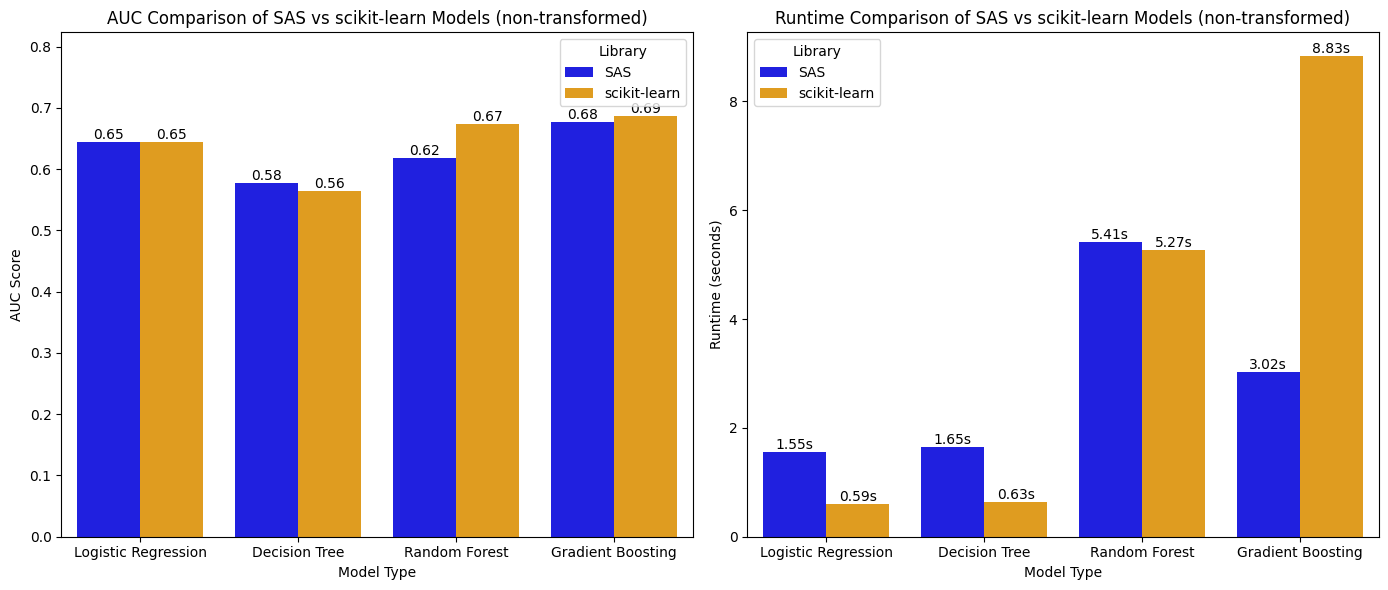

In [11]:
plot_auc_and_runtime(no_tfm_metrics_df, data_version='non-transformed')

The plots reveal that both libraries achieve similar AUC scores. However, there are notable differences in runtimes:

- **Logistic Regression** and **Decision Tree** models in `scikit-learn` run approximately twice as fast as their `sasviya` counterparts. However, the `scikit-learn` Decision Tree exhibits higher overfitting when both libraries' models use default settings.
- **Gradient Boosting** in `sasviya` is significantly more efficient, training 3.5 times faster than the `scikit-learn` version.

#### Hyperparameter Tuning and Model Selection

In this section, we perform hyperparameter tuning using the [Optuna](https://optuna.org/) library, an open-source tool for automated hyperparameter optimization. Optuna employs techniques like *Tree-structured Parzen Estimator (TPE)* to efficiently explore parameter space and select the best model. We consider both `scikit-learn` and `sasviya` implementations for the following classifiers:
- Random Forest
- Decision Tree
- Gradient Boosting

The hyperparameters are tuned based on the cross-validated AUC scores, ensuring the model's ability to generalize well to unseen data.

The code below demonstrates the following steps:
1. Creating an Optuna study to search for the best hyperparameters.
2. Retraining the model on the entire training set using the optimal hyperparameters.
3. Evaluating the best-performing model on both the training and test sets using AUC scores.

In [12]:
objective = Objective(X_train_no_tfm, y_train_no_tfm, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-12 16:35:05,957] A new study created in memory with name: no-name-fcb001d9-77e0-44ee-ae62-30c73e512c06
[I 2025-02-12 16:35:07,864] Trial 0 finished with value: 0.6501535419058299 and parameters: {'classifier': 'rf', 'library': 'sasviya', 'resampling': True, 'sampling_strategy': 0.34499039920047153, 'rf_n_estimators': 95, 'rf_max_depth': 12, 'rf_min_samples_leaf': 27, 'rf_bootstrap': 0.5146481590837378, 'rf_n_bins': 32}. Best is trial 0 with value: 0.6501535419058299.
[I 2025-02-12 16:35:08,167] Trial 1 finished with value: 0.5945488473364532 and parameters: {'classifier': 'dtree', 'library': 'sklearn', 'resampling': True, 'sampling_strategy': 0.416155033530333, 'dtree_max_depth': 14, 'dtree_min_samples_leaf': 10}. Best is trial 0 with value: 0.6501535419058299.
[I 2025-02-12 16:35:08,689] Trial 2 finished with value: 0.5698070669550109 and parameters: {'classifier': 'dtree', 'library': 'sklearn', 'resampling': False, 'dtree_max_depth': 15, 'dtree_min_samples_leaf': 5}. Best 

In [13]:
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:5]

for i, trial in enumerate(top_trials):
    print(f"Top {i+1}: Trial {trial.number}, Value: {trial.value}")
    print("  Hyperparameters:")
    print("  ", trial.params)
    print("------------------------------------------")

Top 1: Trial 46, Value: 0.6861434313283429
  Hyperparameters:
   {'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 86, 'gb_max_depth': 4, 'gb_min_samples_leaf': 5, 'gb_n_bins': 36, 'gb_subsample': 0.7814756962370003, 'gb_learning_rate': 0.1}
------------------------------------------
Top 2: Trial 49, Value: 0.6848437406644253
  Hyperparameters:
   {'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 87, 'gb_max_depth': 4, 'gb_min_samples_leaf': 5, 'gb_n_bins': 42, 'gb_subsample': 0.7200828455430308, 'gb_learning_rate': 0.1}
------------------------------------------
Top 3: Trial 45, Value: 0.6841356166553542
  Hyperparameters:
   {'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 75, 'gb_max_depth': 4, 'gb_min_samples_leaf': 5, 'gb_n_bins': 37, 'gb_subsample': 0.7679205795951264, 'gb_learning_rate': 0.1}
------------------------------------------
Top 4: Trial 30, Value: 0.683399774464104
  Hy

All of the top five trials are Gradient Boosting models, two from the `scikit-learn` library (the first and fifth) and three from the `sasviya` library (the remaining ones). Since their AUC scores are very close, the second-best performing model was chosen as the final one. This decision was based on the fact that the SAS Gradient Boosting model is faster than its `scikit-learn` counterpart, as demonstrated in the previous section.

In [14]:
chosen_hyperparameters = top_trials[1].params
print("Set of chosen hyperparameters:")
print(chosen_hyperparameters)

Set of chosen hyperparameters:
{'classifier': 'gb', 'library': 'sasviya', 'resampling': False, 'gb_n_estimators': 87, 'gb_max_depth': 4, 'gb_min_samples_leaf': 5, 'gb_n_bins': 42, 'gb_subsample': 0.7200828455430308, 'gb_learning_rate': 0.1}


In [15]:
best_pipeline = create_best_pipeline(chosen_hyperparameters, preprocessor)
best_pipeline.named_steps['model'].calc_feature_importances  = True
best_pipeline = train_pipeline(best_pipeline, X_train_no_tfm, y_train_no_tfm, chosen_hyperparameters)
cat_levels = best_pipeline.named_steps['cat_filter'].levels
# valid_rows_mask_train = X_train_no_tfm[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
valid_rows_mask_test = X_test_no_tfm[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
# y_train = y_train[valid_rows_mask_train]
y_test_no_tfm = y_test_no_tfm[valid_rows_mask_test]

auc_train, auc_test = compute_auc(best_pipeline, X_train_no_tfm, y_train_no_tfm, X_test_no_tfm, y_test_no_tfm)
print(f"- AUC score on the train set: {auc_train:.2f}")
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the train set: 0.84
- AUC score on the test set: 0.70


### Model Building for transformed dataset

Now, we apply the same modeling approach to the transformed dataset. The preprocessing steps, which include encoding categorical features, are preserved, and the models are evaluated in the same way.

In [16]:
merged_df_tfm = pd.read_csv(f"{repo_path}/data/merged_data_tfm.csv")

In [17]:
X_train_tfm, X_test_tfm, y_train_tfm, y_test_tfm, cat_cols_tfm, cat_cols_with_two_values_tfm, cat_cols_with_more_values_tfm, numeric_cols_tfm = split_data_and_generate_column_lists(merged_df_tfm, target)

- Number of rows with churn='No': 13069 (90.32 %)
- Number of rows with churn='Yes': 1401 (9.68 %)


In [18]:
metrics_list = []

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values_tfm)), cat_cols_with_two_values_tfm),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values_tfm)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

models = [
    (SASLogisticRegression(), "Logistic Regression", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor),('classifier', SKLogisticRegression(solver='liblinear'))]), "Logistic Regression", "scikit-learn"),
    (SASDecisionTreeClassifier(), "Decision Tree", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKDecisionTreeClassifier())]), "Decision Tree", "scikit-learn"),
    (SASForestClassifier(), "Random Forest", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKRandomForestClassifier())]), "Random Forest", "scikit-learn"),
    (SASGradientBoostingClassifier(), "Gradient Boosting", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKGradientBoostingClassifier())]), "Gradient Boosting", "scikit-learn")
]

for model, model_name, library in models:
    start_time = time.time()
    if library == 'SAS' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_tfm, y_train_tfm, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols_tfm, nominals=cat_cols_tfm)
    elif library == 'SAS' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_tfm, y_train_tfm, model, model_name, library, k=k, resampling=False, nominals=cat_cols_tfm)
    elif library == 'scikit-learn' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_tfm, y_train_tfm, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols_tfm)
    elif library == 'scikit-learn' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train_tfm, y_train_tfm, model, model_name, library, k=k, resampling=False)
    end_time = time.time()
    metrics["Runtime"] = end_time - start_time
    metrics_list.append(metrics)
    print(f"The {model_name} model from the {library} library has been trained.")
    print(f"Runtime: {end_time - start_time:.2f} s")
        
tfm_metrics_df = pd.concat(metrics_list, ignore_index=True)
tfm_metrics_df

The Logistic Regression model from the SAS library has been trained.
Runtime: 74.61 s
The Logistic Regression model from the scikit-learn library has been trained.
Runtime: 71.86 s
The Decision Tree model from the SAS library has been trained.
Runtime: 75.06 s
The Decision Tree model from the scikit-learn library has been trained.
Runtime: 70.16 s
The Random Forest model from the SAS library has been trained.
Runtime: 78.99 s
The Random Forest model from the scikit-learn library has been trained.
Runtime: 74.46 s
The Gradient Boosting model from the SAS library has been trained.
Runtime: 75.25 s
The Gradient Boosting model from the scikit-learn library has been trained.
Runtime: 79.25 s


,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std,Runtime
0,Logistic Regression,SAS,0.662,0.633,0.003,0.009,74.605098
1,Logistic Regression,scikit-learn,0.661,0.633,0.004,0.009,71.859836
2,Decision Tree,SAS,0.650,0.597,0.004,0.010,75.059168
3,Decision Tree,scikit-learn,1.000,0.558,0.000,0.008,70.157265
4,Random Forest,SAS,0.833,0.628,0.005,0.010,78.987826
5,Random Forest,scikit-learn,1.000,0.660,0.000,0.008,74.463452
6,Gradient Boosting,SAS,0.895,0.664,0.005,0.016,75.247992
7,Gradient Boosting,scikit-learn,0.808,0.684,0.005,0.006,79.253338


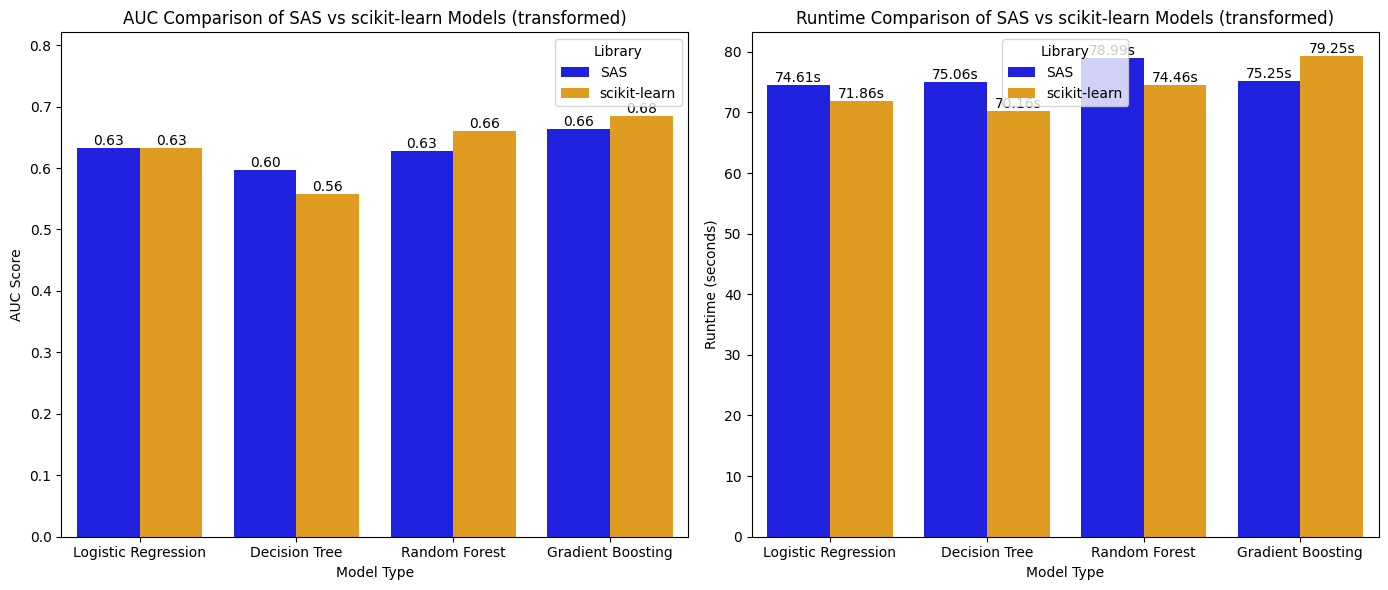

In [19]:
plot_auc_and_runtime(tfm_metrics_df, data_version='transformed')

The AUC improvement from the non-transformed dataset to the transformed dataset is marginal, indicating that the feature transformation did not significantly improve model performance. Given that the runtimes are also higher in this case (due to the missing value imputation of some engineered features, see Part 2) and interpretability would be more challenging, we decided to retain the model identified through the hyperparameter tuning procedure on the non-transformed dataset.

**Note**: Considering all the data transformations at once might not provide a complete understanding of which feature engineering tasks truly contribute to improving model performance and which do not. Therefore, it could be beneficial to experiment with one data transformation step at a time, or explore new transformations. However, this approach was not explored in this notebook.

### Model Interpretability and Cutoff optimization

We selected the SAS Gradient Boosting model, specifically the version with hyperparameters stored in the `chosen_hyperparameters` variable, to identify potential churners in our customer base and take action to retain them. Before optimizing the probability cutoff for profit maximization, let's first examine the **feature importance** for this model:

In [20]:
feature_importances = best_pipeline.named_steps['model'].feature_importances_
feature_importances

,Variable,Importance,Std,Count
0,margin_net_pow_ele,7.142040,9.174839,135.0
1,days_to_end,5.398801,5.958832,132.0
2,cons_last_month,3.484613,3.923748,88.0
3,pow_max,2.942771,3.753179,76.0
4,net_margin,2.933178,3.438188,77.0
5,forecast_meter_rent_12m,2.195596,2.776686,70.0
6,origin_up,2.168173,6.321184,29.0
7,price_off_peak_var_std,1.795974,2.602878,51.0
8,num_years_antig,1.736981,4.086122,32.0
9,contract_age_at_last_modif,1.707365,2.046834,52.0


The results show that `margin_net_pow_ele` and `days_to_end` are the most influential features in predicting churn and enhancing the model's performance. To gain deeper insights into how these variables affect churn likelihood (i.e., whether they increase or decrease churn probability and the nature of their relationship), we could use additional model interpretability techniques such as **SHAP values**, **Partial Dependence (PD) plots**, **Individual Conditional Expectation (ICE) plots**, and **Local Interpretable Model-Agnostic (LIME) explanations**. However, we will not explore these techniques further in this notebook.

Next, we will focus on optimizing the probability cutoff for maximum profit.

Assume that to prevent a client from churning, PowerCo offers a 10% discount on their electricity price. We also assume that the discount has an 80% efficiency, meaning that 80% of the targeted at-risk customers who receive the discount are persuaded to stay.

Although PowerCo is willing to offer discounts to retain customers, they don't want to give discounts to customers who would have stayed without it. Therefore, we need to identify the optimal churn probability threshold that maximizes PowerCo's overall profit. To estimate this optimal probability cutoff, we will use the test set to simulate how the model would perform on unseen data.

To this aim, we can compute for different probability thresholds the profit function as:
$$
\text{Profit}(p)=\text{Gains}-\text{Loss}+\text{Prevented Loss}-\text{Discount Loss}
$$
where:
- **Gains** represents the total potential profit if no customers churn, therefore this value assumes a perfect scenario where all customers are retained. The profit represents the average annual profit and has been calculated using the `margin_net_pow_ele` variable, which denotes the net margin on power subscriptions. This margin is assumed to refer to the average monthly margin and was therefore multiplied by 12 to derive the annual value.
- **Loss** represents the total profit lost due to customers who churned. This value accounts for the revenue lost because these customers are no longer contributing profit.

For each scenario, the retention campaign targets all customers with a predicted churn likelihood exceeding the probability threshold, $p$. 
- **Prevented Loss** is the profit gained from customers who were predicted to churn and actually churned, but would've been retained due to the campaign. This is scaled by the discount efficiency.
$$
\text{Prevented Loss}=\text{Sum of profits from targeted churners}\times\text{Discount Efficiency}
$$
- **Discount Loss** represents the total cost of offering discounts to targeted high-risk customers, broken down as follows:
    - **For non-churners**: The profit from customers who were predicted to churn but did not actually churn, multiplied by the discount rate, as they would've been targeted by the campaign.
        $$
        \text{Discount Loss (Non-Churners)} = \text{Sum of profits from targeted non-churners}\times\text{Discount Rate}
        $$
    - **For Churners**: The prevented loss scaled by the discount rate.
        $$
        \text{Discount Loss (Churners)} = \text{Prevented Loss}\times\text{Discount Rate}
        $$
    The total discount loss is the sum of these two components:
    $$
    \text{Discount Loss} = \text{Discount Loss (Non-Churners)} + \text{Discount Loss (Churners)}
    $$
    **Note**: In our example, we might assume that the discount is operated on the net margin (`margin_net_pow_ele` variable, which is only a component of the total tariff), to make computations easier, but it should be actually properly defined what a 10% tariff discount means.

Then, choose the threshold $p^*$ leading to the highest profit, given by $Profit(p^*)$.
We can compare this situation with what would’ve happened if we didn’t do anything:
$$
\text{Profit}=\text{Gains}-\text{Loss}
$$
to compute the financial impact of our model (percent improvement in profit). This value represents the baseline scenario in which no effort is made to prevent churn, and the business simply absorbs the loss from churned customers.

A <u>lower</u> probability threshold expands the retention campaign to more customers, leading to a higher `Discount Loss`.<br>Conversely, a <u>higher</u> probability threshold excludes some potential churners from the discount offer, increasing the risk of losing them and, therefore, decreasing the `Prevented Loss` term.

Optimal threshold: 0.1206
At this threshold, apply a 10.0% discount to identified high-risk customers.
Estimated financial impact: 23895.49 € (3.16% increase in profit compared to no intervention).
688 out of 2911 customers (23.63%) would receive the discount.


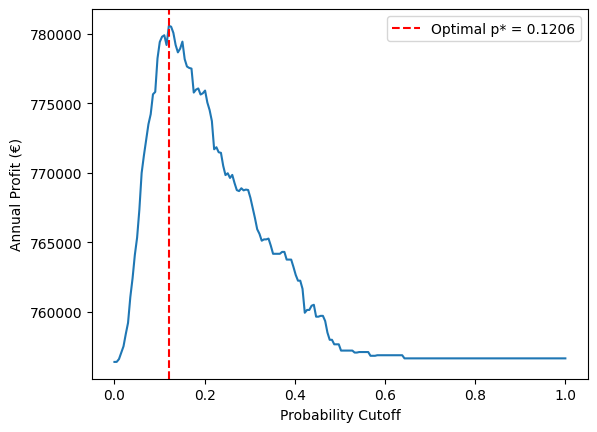

In [26]:
margins = X_test_no_tfm['margin_net_pow_ele']

y_pred_proba = best_pipeline.predict_proba(X_test_no_tfm).iloc[:,1]
optimize_discount_strategy(y_test_no_tfm, y_pred_proba, margins, discount_rate=0.1, discount_efficiency=0.8)

### Next Steps

- Both when predicting a customer's churn likelihood and when determining the discount to offer a potential churner, considering **competitor tariffs** could be valuable. 
This can be achieved by introducing a new variable, such as `competitor_avg_tariff_lastmonth`, which represents the average tariff for the last month of the historical data period. This value can be calculated using data from sources like CHECK24, taking into account the *postal code* and the *number of kilowatt-hours consumed* (based on actual or estimated readings). These two inputs are essential for CHECK24's tariff comparisons, helping users identify the most competitive offers.<br>The discount is an hyperparameter of the model, in a sense, that can be tuned based on how much increase in profit you want to achieve and/or on the average current competitor price for the customer we are considering. For example, based on postal code and number of kWh consumed, the average competitor price can change, and then considering the percent difference between PowerCo tariff and average tariff can help us choose the discount needed in order for it to be effective.
- An additional step that could enhance the analysis is performing **customer segmentation** prior to training the churn model. By using clustering techniques, we could train separate churn models for each customer segment, allowing us to better understand the distinct patterns within different types of customers. This approach was not implemented in this project due to the limited data available for training, but it could provide valuable insights and improve the model's performance in the future.
- As mentioned earlier, it could be valuable to experiment with **one data transformation step at a time**, rather than considering all transformations at once. This would allow for a better understanding of which feature engineering tasks genuinely contribute to improving model performance. Additionally, exploring new transformations could lead to further enhancements.

### Conclusions

To wrap up, this project focused on churn prediction for an energy company using data from the `'client_data_raw.csv'` and `'price_data_raw.csv'` files. The workflow was divided into three main parts:

- **Data Quality and Preprocessing** (`'Churn Prediction - Part 1'`):
    - We began by inspecting variable types and conducting data quality checks.
    - Inconsistent rows were identified, removed, and saved to CSV files for further investigation with the data provider.
- **Feature Engineering and Data Transformation** (`'Churn Prediction - Part 2'`):
    - We imputed missing values in price trends, summarized price data for each customer ID, merged the datasets, and saved a non-transformed version of the table.
    - Several feature engineering and data transformation steps were applied to prepare the data for modeling, resulting in a transformed version of the table.
- **Model Building and Evaluation** (`'Churn Prediction - Part 3'`):
    - We trained and compared multiple machine learning models using both `scikit-learn` and SAS via the **Python API in SAS Viya Workbench**.
    - Model selection was performed using `Optuna` for hyperparameter tuning, and model performance was evaluated using cross-validated AUC scores.
    - After selecting the best-performing model, we retrained it on the entire training set.
    - We determined the optimal probability cutoff to maximize company profit, simulating a retention campaign where discounts were offered to customers predicted as likely churners. The cutoff optimization was tailored based on assumed retention efficiency and discount rates.

By following this structured approach, we provided a comprehensive framework for churn prediction, enabling the energy company to enhance its retention strategies, minimize customer loss, and maximize its profit effectively.